In [42]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

dataroot = '../WaterLevelPrediction_SelectingModel//Data/'

In [12]:
df = pd.read_pickle(dataroot+'finaldata.pkl')

In [13]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=365)
df = df.sort_index()

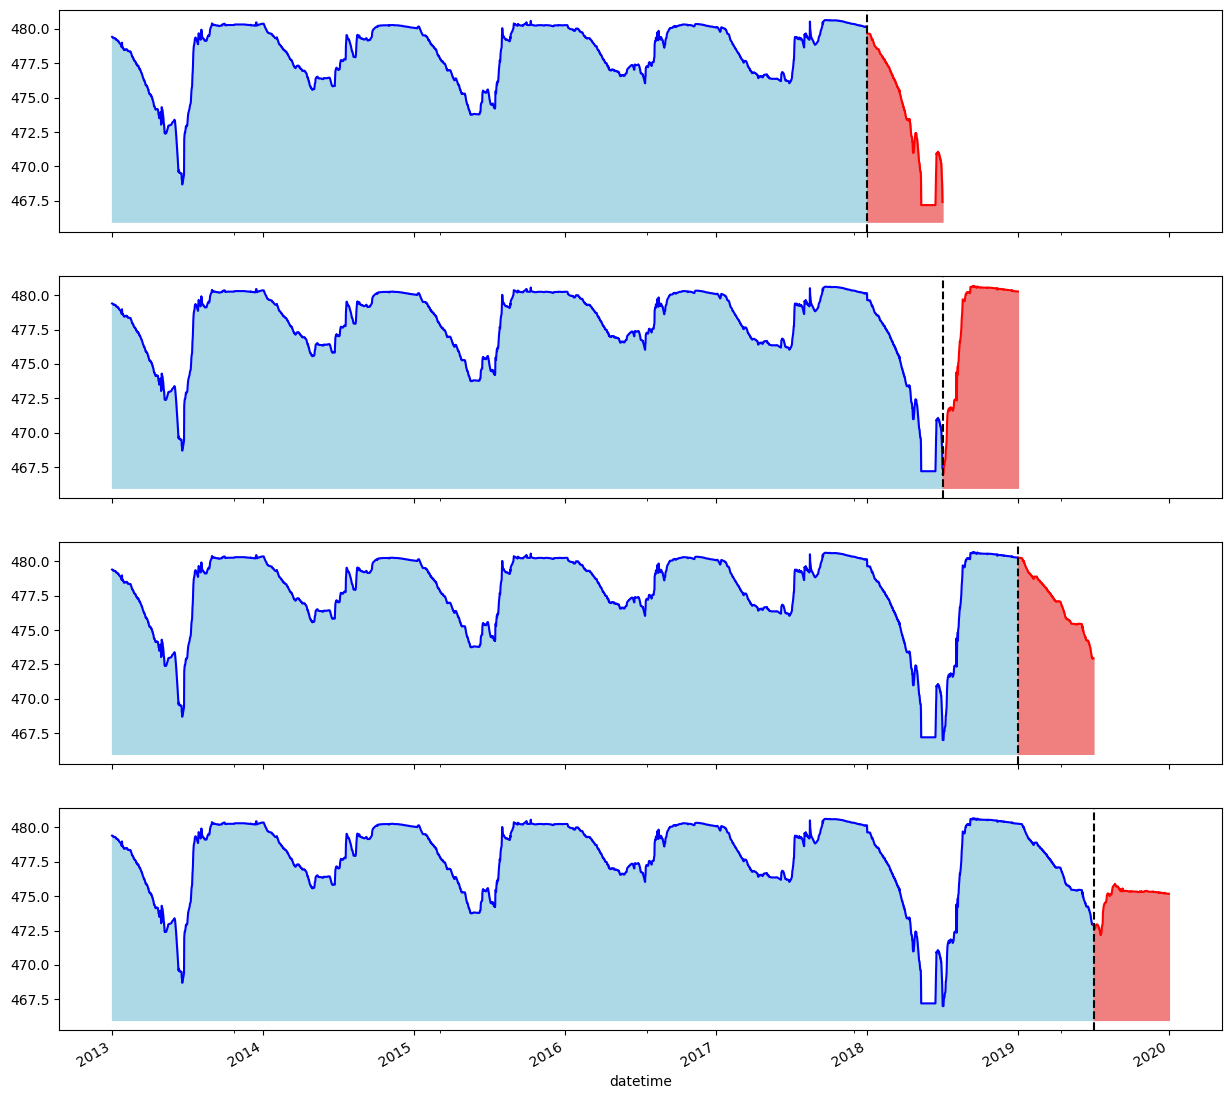

In [14]:
fig, axs = plt.subplots(4,1, figsize = (15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['water_level'].plot(ax=axs[fold],
                              label='Tập huấn luyện',
                              color='blue')
    test['water_level'].plot(ax=axs[fold],
                             label='Tập kiểm thử',
                             color='red')
    axs[fold].fill_between(train.index,466, train['water_level'], color='lightblue')
    axs[fold].fill_between(test.index,466, test['water_level'], color='lightcoral')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1
plt.show()

In [15]:
# Create Lag Feature
def add_lag(df):
    target_map = df['water_level'].to_dict() # mapping water level
    df['lag'] = (df.index - pd.Timedelta('12 hours')).map(target_map)
    return df

df = add_lag(df)
df = df.dropna(subset=['lag'])# drop the NaN value because model won't accept it
df.head()


,year,month,day,water_level,hour,precipitation,sluice_status,datetime,lag
datetime,,,,,,,,,
2013-01-01 19:00:00,2013,1,1,479.38,19,0.0,0,2013-01-01 19:00:00,479.40
2013-01-02 07:00:00,2013,1,2,479.37,7,0.0,5,2013-01-02 07:00:00,479.38
2013-01-02 19:00:00,2013,1,2,479.36,19,0.0,5,2013-01-02 19:00:00,479.37
2013-01-03 07:00:00,2013,1,3,479.36,7,0.0,5,2013-01-03 07:00:00,479.36
2013-01-03 19:00:00,2013,1,3,479.36,19,0.0,5,2013-01-03 19:00:00,479.36


In [16]:
from sklearn.linear_model import LinearRegression

fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    
    y_pred = lin_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

In [17]:
print (lin_reg.coef_)
print (lin_reg.intercept_)

[ 0.00644869 -0.00267391  1.00092908]
-0.4516785654461728


In [18]:
print(f'mean squared error across fold:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(maes)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each fold:{r2s}')

mean squared error across fold:0.11287994024306053
score for each fold:[0.1668414386644875, 0.19194242072554707, 0.040487465673760804, 0.052248435908446744]
mean absolute error across fold:0.04631170761975395
score for each fold:[0.07117766291319372, 0.061903390542841885, 0.026107344529493762, 0.026058432493486435]
r2 score across fold:0.9980469636955345
score for each fold:[0.9984564195330042, 0.9975980233749445, 0.999566471600936, 0.9965669402732533]


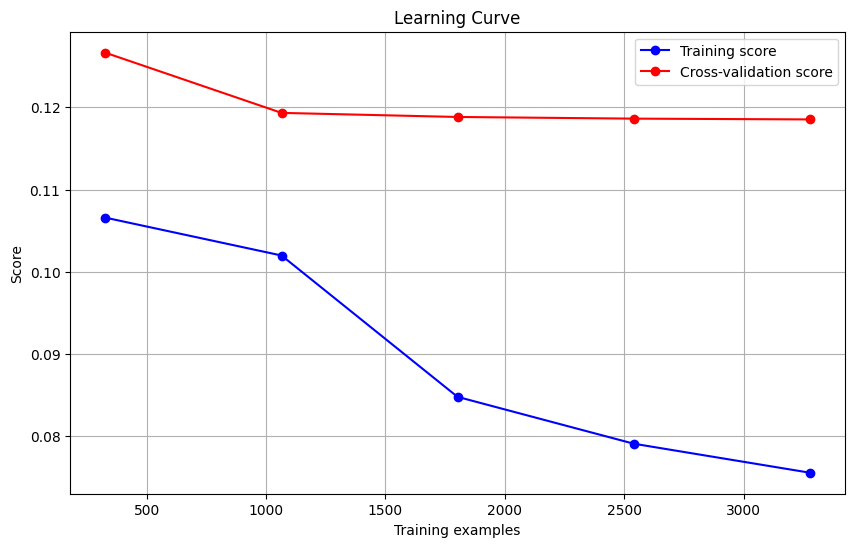

In [51]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve

scorer = make_scorer(lambda y_test, y_pred: np.sqrt(mean_squared_error(y_test, y_pred)))

train_sizes, train_scores, test_scores = learning_curve(lin_reg, X_train, y_train, cv=tss, scoring=scorer)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

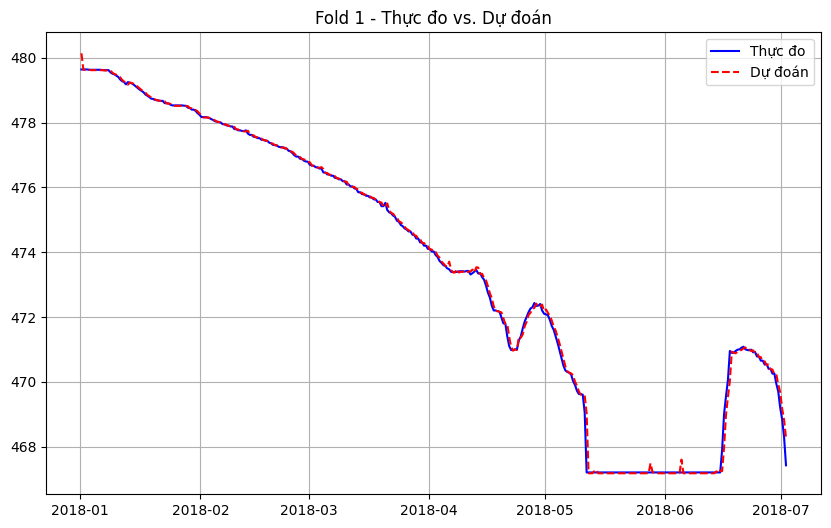

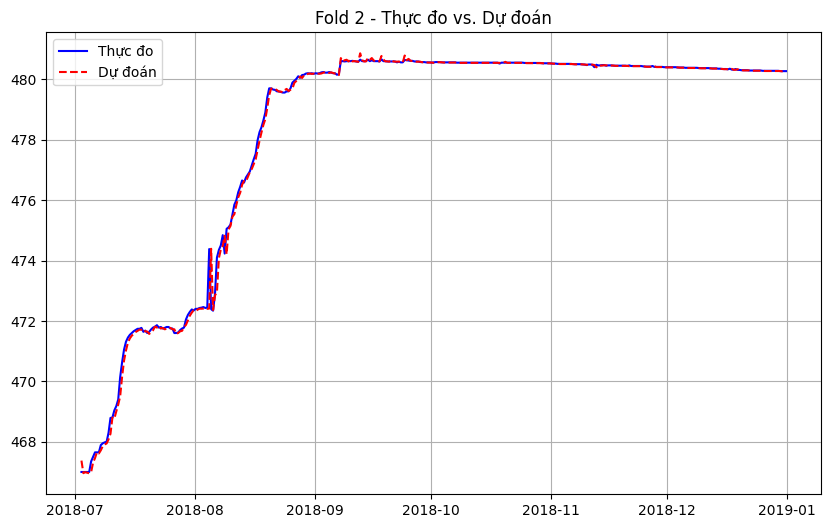

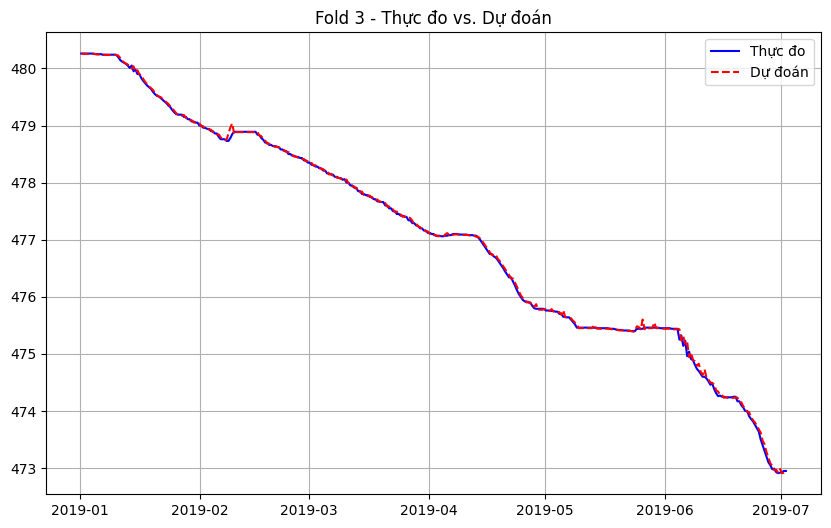

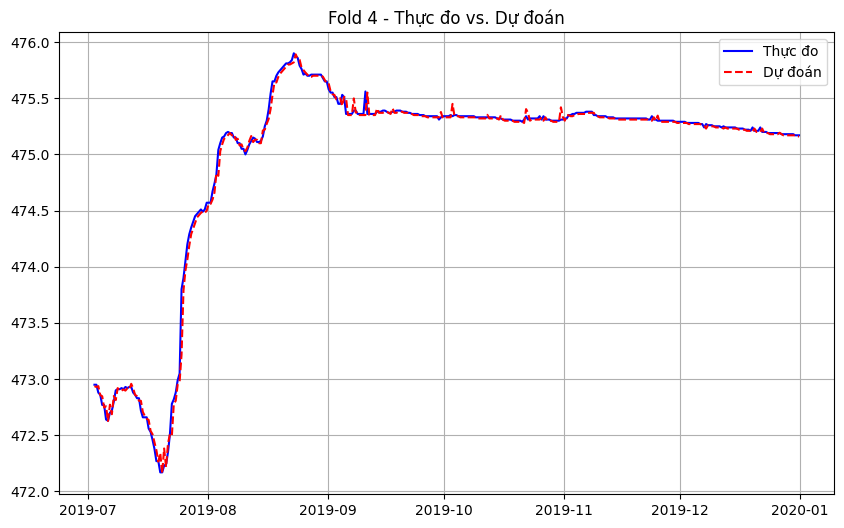

In [19]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['water_level'], label='Thực đo', color='blue')
    plt.plot(test.index, preds[fold], label='Dự đoán', color='red', linestyle='dashed')
    fold += 1

    plt.title('Fold {} - Thực đo vs. Dự đoán'.format(fold))

    plt.legend()
    plt.grid()
    plt.show()

In [20]:
# Retrain the model with all data
X_all = df[features]
y_all = df[target]

lin_reg = LinearRegression()
lin_reg.fit(X_all, y_all)

LinearRegression()

In [21]:
# print (lin_reg.coef_)
# print (lin_reg.intercept_)

In [ ]:
# Save the model
import joblib
lin_reg_file = 'linear_regression.joblib'
joblib.dump(lin_reg, lin_reg_file)

['linear_regression.joblib']

In [ ]:
loaded_model = joblib.load(lin_reg_file)

X_new = pd.DataFrame({'precipitation': [28], 'sluice_status': [1], 'lag': [480.48]})
prediction = loaded_model.predict(X_new)

print("Prediction:", prediction)


Prediction: [480.65159557]
